In [27]:
import numpy as np
from matplotlib import rcParams 
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
rcParams['figure.figsize'] = [18, 5]
rcParams['font.size'] =14
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [14]:
#Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [15]:
#data loading
alldata = np.array([])
for j in range(len(fname)):
  alldata = np.hstack((alldata, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [16]:
#Fields available for every session
dat11=alldata[11]
print(dat11.keys())

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [17]:
# Available recordings from brain areas in each session
c=np.arange(0, 39, 1)

for i in c:
  datt = alldata[i]
  list_brain_areas = list(dict.fromkeys(datt['brain_area']))
  print("Session", i+1, ".", "Areas available:", list_brain_areas)

Session 1 . Areas available: ['ACA', 'MOs', 'LS', 'root', 'VISp', 'CA3', 'SUB', 'DG']
Session 2 . Areas available: ['CA1', 'VISl', 'root', 'VISpm', 'POST']
Session 3 . Areas available: ['DG', 'VISam', 'MG', 'CA1', 'SPF', 'root', 'LP', 'MRN', 'POST', 'NB', 'VISp']
Session 4 . Areas available: ['LGd', 'DG', 'TH', 'SUB', 'VPL', 'VISp', 'CA1', 'VISa', 'LSr', 'ACA', 'MOs']
Session 5 . Areas available: ['VISa', 'root', 'CA1', 'SUB', 'DG', 'OLF', 'ORB', 'ACA', 'PL', 'MOs']
Session 6 . Areas available: ['AUD', 'root', 'SSp', 'CA1', 'TH']
Session 7 . Areas available: ['VPL', 'root', 'CA3', 'LD', 'CP', 'EPd', 'SSp', 'PIR']
Session 8 . Areas available: ['ILA', 'TT', 'MOs', 'PL', 'LSr', 'root', 'LD', 'PO', 'CA3', 'VISa', 'CA1', 'LP', 'DG', 'VISp', 'SUB']
Session 9 . Areas available: ['TT', 'ORBm', 'PL', 'LSr', 'root', 'CA3', 'VISl', 'CA1', 'TH', 'VISam', 'VPL', 'LD']
Session 10 . Areas available: ['MB', 'VISp', 'SCm', 'SCsg', 'POST', 'DG', 'MRN', 'CA1', 'VISl', 'POL', 'root', 'GPe', 'VISrl']
Sessi

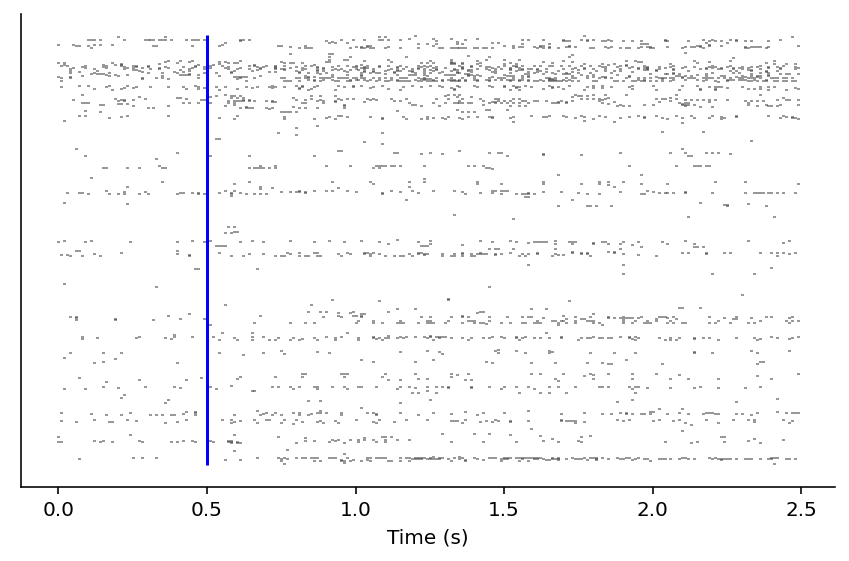

In [18]:
# Find the raster plot for certain brain areas, for certain session, all neurons and trials


def raster_everything(session, raster_area):
  dat = alldata[session-1]
  area = dat['brain_area'] #take all the brain areas from session 1
  ind_area = np.where(area==raster_area)[0] #indices for CA1
  spikes = dat['spks'] 
  trials = spikes[0,:,0]
  ind_trial = np.arange(0, len(trials)) #an array with the number of trials
  
  time = np.arange(0,dat['spks'].shape[-1] * 0.01 ,0.01)
  spike_times = []

  for j in ind_area:
    for i in ind_trial:
      neuron_spikes = dat['spks'][j,i,:]
  
      indexes = np.where(neuron_spikes == 1)[0]
    
      spike_times.append([time[k] for k in indexes])
 
  plt.eventplot((spike_times), color=".2")
  plt.xlabel("Time (s)")
  plt.yticks([]);
  plt.vlines(0.5, 0, len(spike_times), colors='b') #stimulus presentation

# Example for dat['brain_area'] = 'CA1'
raster_everything(27,'VISam')


In [25]:
#A function that creates a peri-stimulus time histogram, 0.5 sec before and after stimulus presentation

def psth_feedback(session, area, feedback):
  dat = alldata[session-1]
  plusone_indx = np.where(dat['feedback_type'] == feedback)[0]


  #Time = 2,5 second divided by 10ms bins
  time = np.arange(0,dat['spks'].shape[-1] * 0.01 ,0.01) 
  spike_times_plusone_area = []
  ind_area = np.where(dat['brain_area']==area)[0] #indices for CA1
  for x in plusone_indx:
    neurons_plusone_area = dat['spks'][ind_area,x,0:101]
    for j in neurons_plusone_area:
      #Spikes_indexes_plusone_area indexes of spikes in neurons with +1 feedback
      spikes_indexes_plusone_area = np.where(j == 1)[0]
      spike_times_plusone_area.append([time[k] for k in spikes_indexes_plusone_area])
      spike_times_plusone_area = [x for x in spike_times_plusone_area if x != []]      
      
  
  plt.figure()
  psthspks = []
  for x in spike_times_plusone_area:
    for j in x:
      psthspks.append(j)
  y, x, _ = plt.hist(psthspks, 50,range=[0,1], color='c')
  plt.vlines(0.5, 0, y.max(),  colors='r', linestyles='dashdot')
  plt.rcParams["figure.figsize"] = (12,10)
  
 

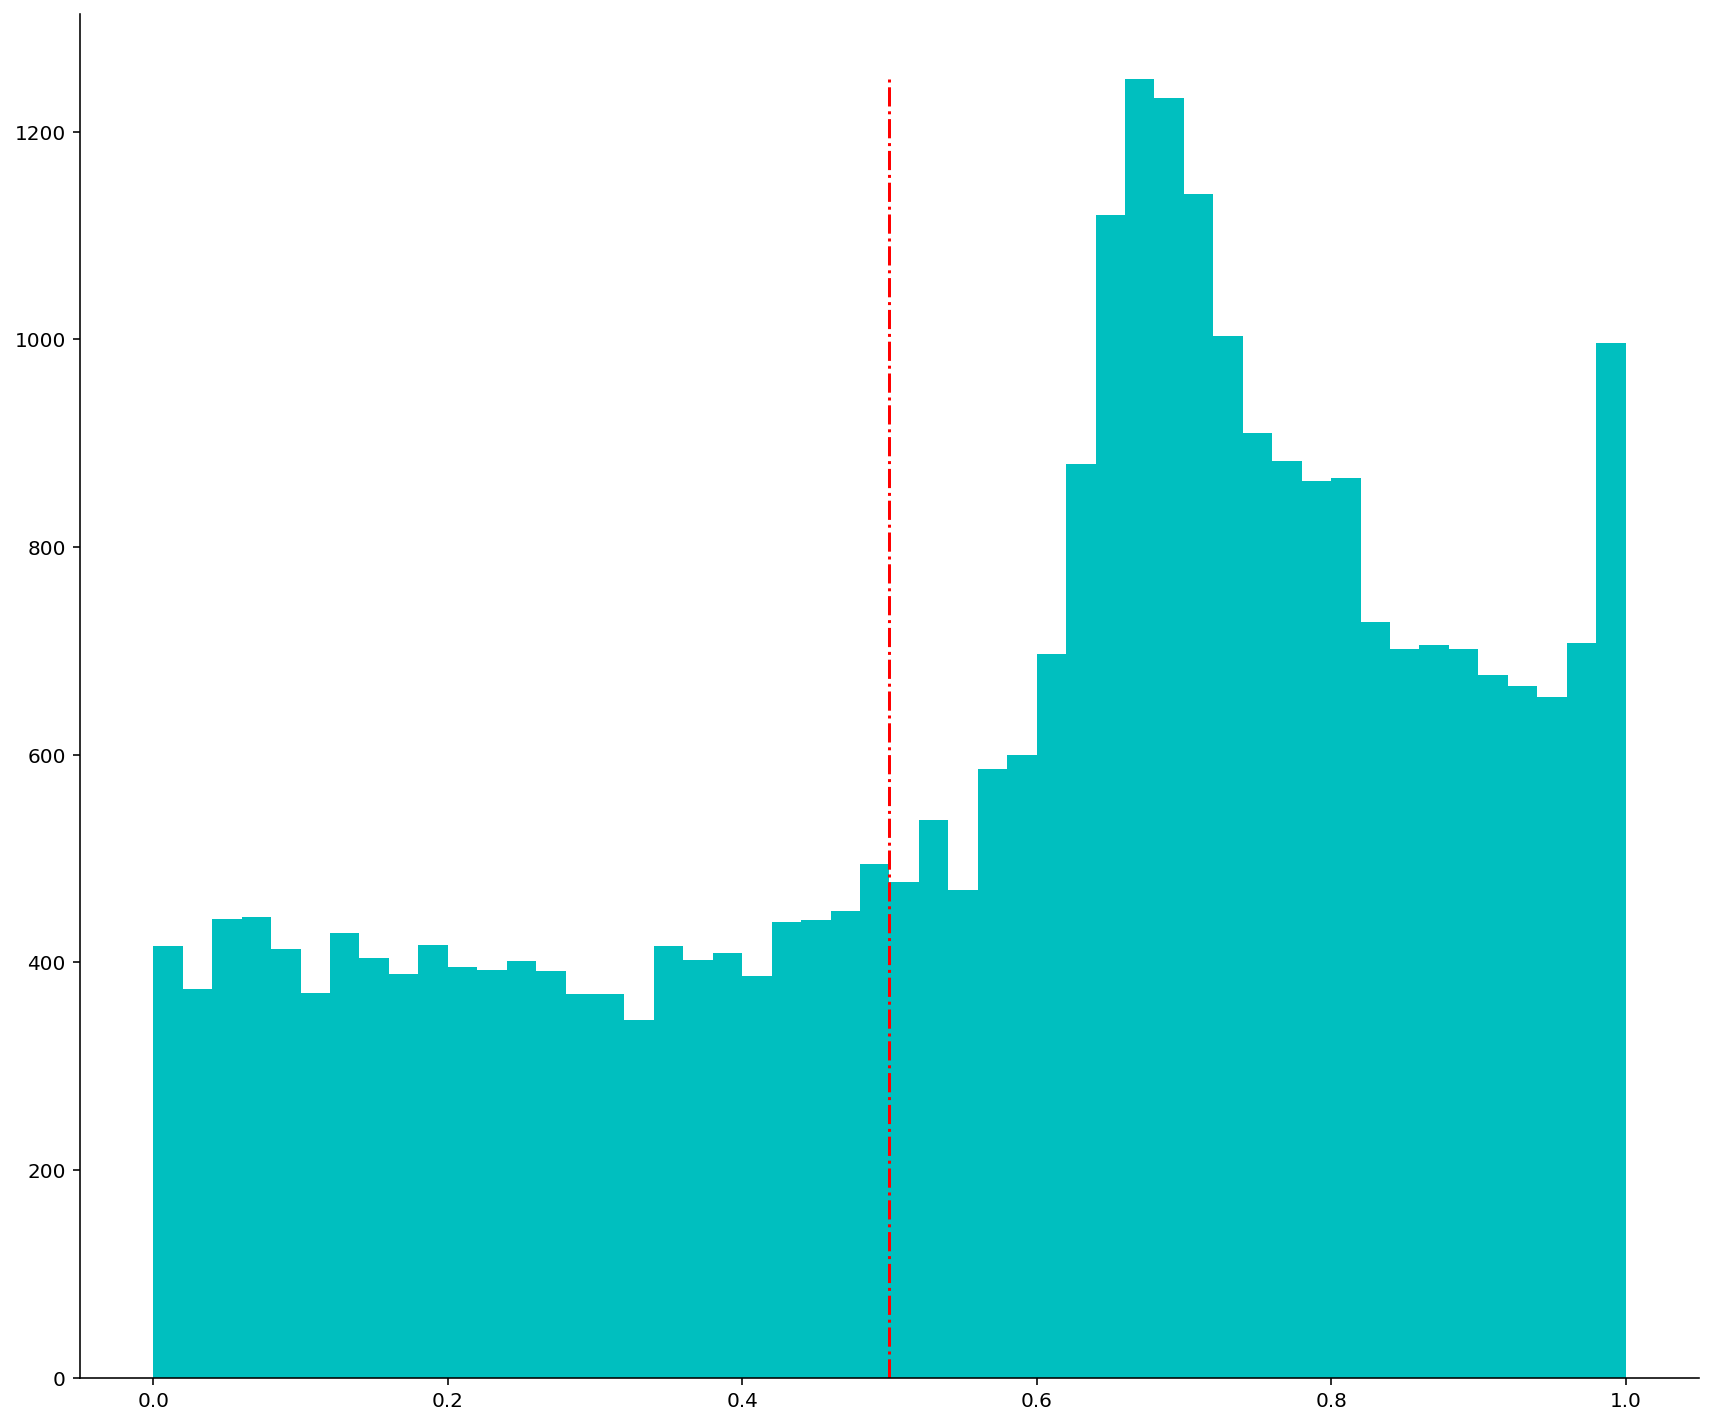

In [26]:
psth_feedback(1, 'ACA', +1)